# Keltner Channel Strategy

In [1]:
from datetime import datetime, timedelta
import logging

from alpaca.data.timeframe import TimeFrame, TimeFrameUnit
import pandas as pd
from talib import ATR, EMA, RSI

from examples.data import (
    download_bars,
    separate_bars_by_symbol,
    split_multi_index_bars_train_test,
)

from bacta.backtester import EventBacktester, Order, Position
from bacta.utilities import dash
from bacta.utilities.logger import get_logger, set_log_level

set_log_level(logging.DEBUG)

/usr/local/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class KeltnerChannelBacktester(EventBacktester):
    """
    Backtester that uses the Keltner Channel to make decisions.
    """

    def __init__(self, active_symbols, cash, **kwargs):
        super().__init__(active_symbols, cash, **kwargs)
        self.keltner_channel_period = 21

    def precompute_step(self, bars: pd.DataFrame):
        """
        Preload the indicators for the backtest.
        """

        split_bars = separate_bars_by_symbol(bars)
        self.middle_bands = {symbol: EMA(
            split_bars[symbol].loc[:, "close"], timeperiod=self.keltner_channel_period) for symbol in self.active_symbols}
        self.upper_bands = {symbol: self.middle_bands[symbol] + 2 * ATR(split_bars[symbol].loc[:, "high"], split_bars[symbol].loc[:, "low"],
                                                                        split_bars[symbol].loc[:, "close"], timeperiod=self.keltner_channel_period) for symbol in self.active_symbols}
        self.lower_bands = {symbol: self.middle_bands[symbol] - 2 * ATR(split_bars[symbol].loc[:, "high"], split_bars[symbol].loc[:, "low"],
                                                                        split_bars[symbol].loc[:, "close"], timeperiod=self.keltner_channel_period) for symbol in self.active_symbols}

    def update_step(self, bars: pd.DataFrame, index: pd.Timestamp):
        """
        Update the state of the backtester.
        """
        split_bars = separate_bars_by_symbol(bars)
        self.middle_bands = {symbol: EMA(
            split_bars[symbol].loc[:, "close"], timeperiod=self.keltner_channel_period) for symbol in self.active_symbols}
        self.upper_bands = {symbol: self.middle_bands[symbol] + 2 * ATR(split_bars[symbol].loc[:, "high"], split_bars[symbol].loc[:, "low"],
                                                                        split_bars[symbol].loc[:, "close"], timeperiod=self.keltner_channel_period) for symbol in self.active_symbols}
        self.lower_bands = {symbol: self.middle_bands[symbol] - 2 * ATR(split_bars[symbol].loc[:, "high"], split_bars[symbol].loc[:, "low"],
                                                                        split_bars[symbol].loc[:, "close"], timeperiod=self.keltner_channel_period) for symbol in self.active_symbols}

    def generate_orders(self, bar: pd.DataFrame, index: pd.Timestamp) -> list[Order]:
        """
        Make a decision based on the prices.
        """
        close_prices = bar.loc[:, "close"]
        orders = []
        for symbol in self.active_symbols:
            quantity = round(80 / close_prices[symbol], 4)
            if close_prices[symbol] > self.upper_bands[symbol][index]:
                orders.append(Order(symbol, Position.SHORT,
                              close_prices[symbol], quantity))
            elif close_prices[symbol] < self.lower_bands[symbol][index]:
                orders.append(Order(symbol, Position.LONG,
                              close_prices[symbol], quantity))

        return orders

In [3]:
symbols = ["NRG", "DUK"]

bars = download_bars(
    symbols,
    start_date=datetime(2024, 1, 1),
    end_date=datetime(2025, 7, 31),
    timeframe=TimeFrame(1, TimeFrameUnit.Hour)
)
# split the bars into train and test
train_bars, test_bars = split_multi_index_bars_train_test(
    bars, split_ratio=0.9)

# create the backtester
backtester = KeltnerChannelBacktester(
    symbols,
    cash=2000,
    allow_short=True,
    min_cash_balance=100,
    max_short_value=2000,
    min_trade_value=1,
    market_hours_only=True,
    transaction_cost=0.000,
    transaction_cost_type="percentage",
)

# preload the train bars
backtester.load_train_bars(train_bars)

# run_backtest the backtest
backtester.run_backtest(test_bars)

# plot the order and state history
print(dash("order history"))
print(backtester.get_history())
print(dash("state history"))
print(backtester.get_state_history())

[2025-08-09 12:24:34][DEBUG] Loading data/NRGDUK_2024-01-01_2025-07-31_1Hour.pkl
[2025-08-09 12:24:34][DEBUG] Initializing backtester with active symbols: ['NRG', 'DUK'], cash: 2000, allow_short: True, min_cash_balance: 100, max_short_value: 2000, min_trade_value: 1, market_hours_only: True
[2025-08-09 12:24:34][INFO] Train bars have been previously loaded. Concatenating with test bars...
[2025-08-09 12:24:34][INFO] Running backtest over 15191 bars from 2025-06-03 06:00:00-04:00 to 2025-07-30 18:00:00-04:00...
[2025-08-09 12:24:34][DEBUG] Placing LONG 0.6908 DUK @ $115.800 (2025-06-03 10:00:00-04:00)
[2025-08-09 12:24:35][DEBUG] Placing LONG 0.5076 NRG @ $157.590 (2025-06-04 13:00:00-04:00)
[2025-08-09 12:24:35][DEBUG] Placing SHORT 0.681 DUK @ $117.470 (2025-06-04 13:00:00-04:00)
[2025-08-09 12:24:35][DEBUG] Placing LONG 0.5098 NRG @ $156.920 (2025-06-04 14:00:00-04:00)
[2025-08-09 12:24:35][DEBUG] Placing LONG 0.5111 NRG @ $156.520 (2025-06-04 15:00:00-04:00)
[2025-08-09 12:24:35][DE

- order history ----------------------------------------------------------------
                          symbol  position   price  quantity
2025-06-03 10:00:00-04:00    DUK         1  115.80    0.6908
2025-06-04 13:00:00-04:00    NRG         1  157.59    0.5076
2025-06-04 13:00:00-04:00    DUK        -1  117.47    0.6810
2025-06-04 14:00:00-04:00    NRG         1  156.92    0.5098
2025-06-04 15:00:00-04:00    NRG         1  156.52    0.5111
...                          ...       ...     ...       ...
2025-07-30 14:00:00-04:00    DUK        -1  121.10    0.6606
2025-07-30 15:00:00-04:00    NRG        -1  166.26    0.4812
2025-07-30 15:00:00-04:00    DUK        -1  120.55    0.6636
2025-07-30 16:00:00-04:00    NRG        -1  168.36    6.1874
2025-07-30 16:00:00-04:00    DUK         1  119.56    7.8384

[194 rows x 4 columns]
- state history ----------------------------------------------------------------
                                  cash  portfolio_value     NRG     DUK
0         

In [4]:
# plot the performance
print(dash("performance"))
print(backtester.pretty_format_performance())

- performance ------------------------------------------------------------------
Backtest Performance:
- Return on Investment: 13.24%
- vs. Buy and Hold Return: 3.03%
- Sharpe Ratio: 0.68
- Max Drawdown Percentage: 3.51%

- Start Portfolio Value: $2000.00
- End Portfolio Value: $2264.71
- Min Portfolio Value: $1968.10
- Max Portfolio Value: $2264.71
- Min Cash Balance: $800.04
- Max Cash Balance: $3120.05
- Win Rate: 79.17%

- Number of Orders: 194
- Number of Winning Trades: 152
- Number of Losing Trades: 40
- Avg Trade Return: 2.82%
- Largest Win: 16.83% ($13.46)
- Largest Loss: -6.48% ($-3.73)
- Max Consecutive Wins: 14
- Max Consecutive Losses: 1

- Trading Period Start: 2025-06-03 06:00:00-04:00
- Trading Period End: 2025-07-30 16:00:00-04:00
- Trading Period Length: 57 days 10:00:00
- Time in Market: 99.57%


plotting...


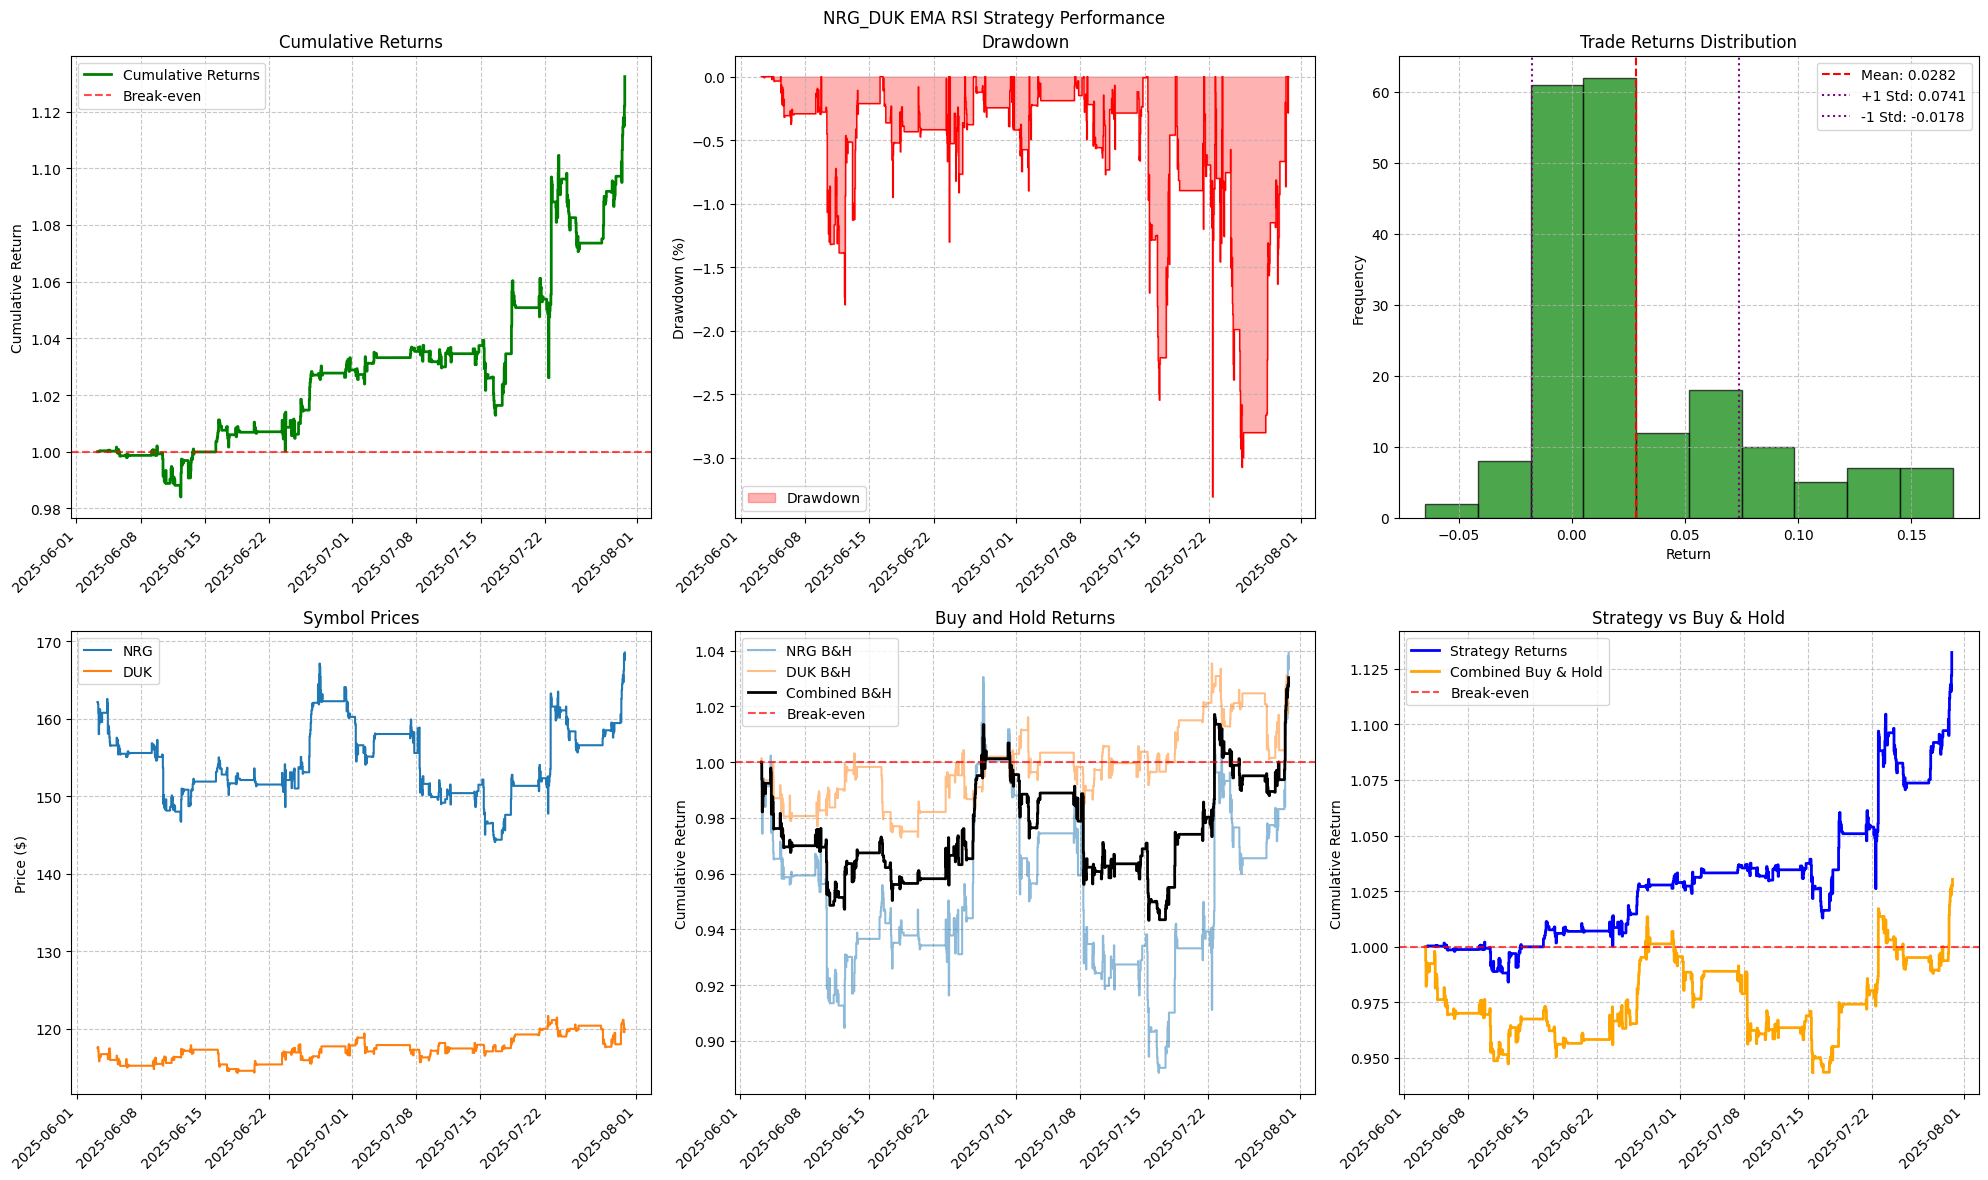

In [5]:
# Plot the results
print("plotting...")
backtester.plot_performance_analysis(
    title="_".join(symbols) + " EMA RSI Strategy Performance", show_plot=False)

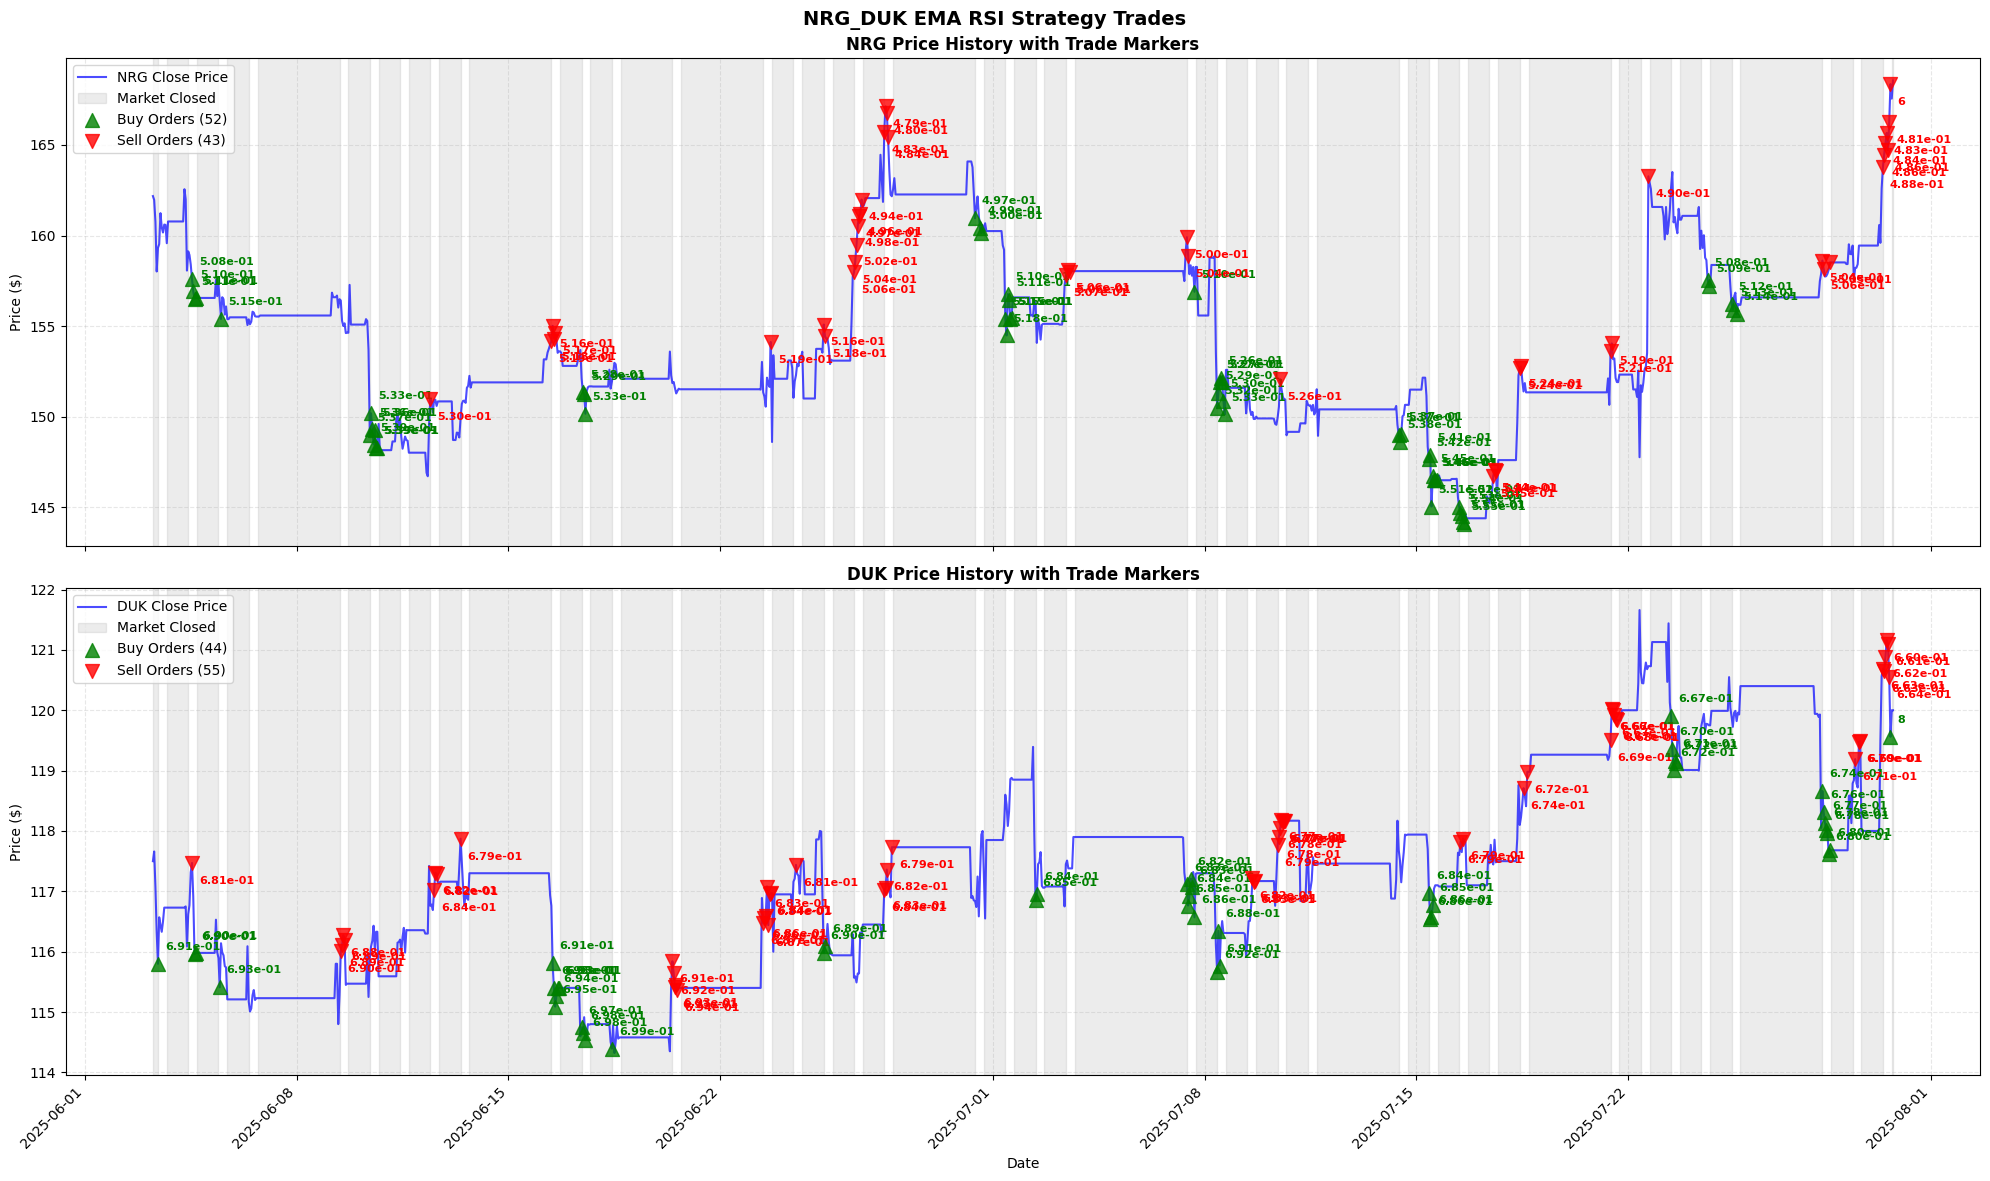

In [6]:
backtester.plot_trade_history(title="_".join(
    symbols) + " EMA RSI Strategy Trades", show_plot=False)

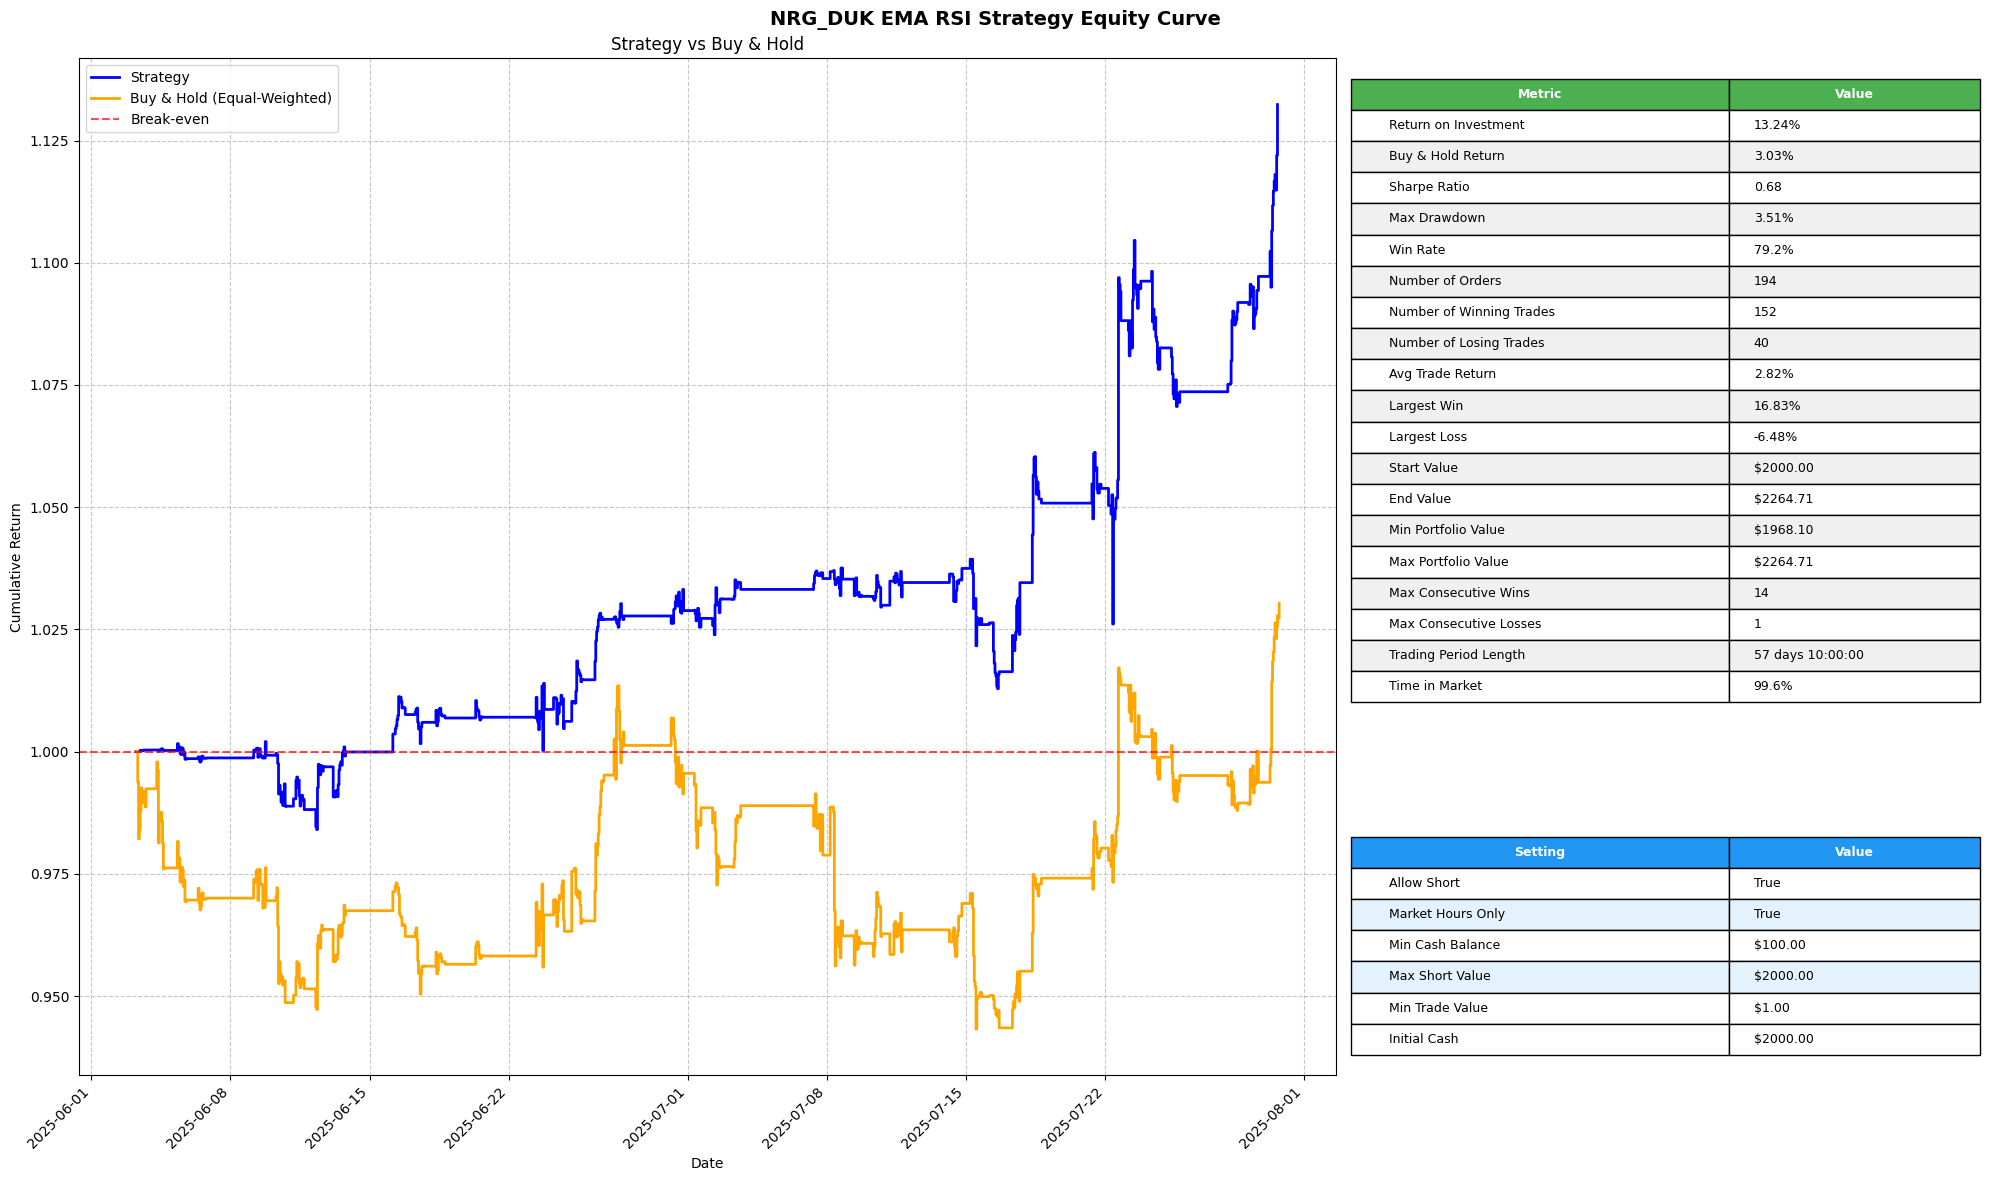

In [7]:
backtester.plot_equity_curve(
    title="_".join(symbols) + " EMA RSI Strategy Equity Curve", show_plot=False
)